# SOME AUXILARY FUNCTIONS

In [ ]:
!nvidia-smi

Mon Apr  1 09:07:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
import numpy as np
import os
import time


import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Your device is: {}'.format(device))

input_shape = 28*28
num_classes = 10
input_channels = 1

def plot_train_process(train_loss, val_loss, val_accuracy):
    clear_output(True)
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))


    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)
    plt.show()

Your device is: cuda:0


In [ ]:

out_dict = dict()

# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist_data'
mkdir(root_path)

download = True
train_transform = transforms.Compose([

     transforms.ToTensor(),
 ])


test_transform = transforms.Compose([
                                       transforms.ToTensor()])


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)



Directory fmnist_data is created!


100%|██████████| 26421880/26421880 [00:02<00:00, 12409431.38it/s]


Extracting fmnist_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 212388.50it/s]


Extracting fmnist_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3866219.72it/s]


Extracting fmnist_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4893988.44it/s]

Extracting fmnist_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist_data/FashionMNIST/raw



In [ ]:
def collect_parameters(model):
  model.eval()
  w1 = []
  w2=  []
  params = []
  for param in model.parameters():
    torch.manual_seed(1)
    w_ = torch.rand_like (param)
    w1.append(w_)
    torch.manual_seed(2)
    w_2 = torch.rand_like (param)
    w2.append(w_2)
    params.append(param.data)
  return w1, w2, params

In [ ]:
def draw_loss_landscape(model, params, w1, w2, train_loader):
  model.eval()
  losses3d = []
  for alpha in alphas:
    loss2d = []
    for beta in betas:
      losses_ = []

      for i, param in enumerate(model.parameters()):
        param.data = params[i] + alpha * w2[i] + beta * w1[i]

      for X_batch, y_batch in train_loader:



        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        predictions = model(X_batch)
        loss =loss_func(predictions, y_batch)
        losses_.append(loss.item())

        break


      loss2d.append(np.mean(losses_))
    losses3d.append(loss2d)

  return losses3d


# UNREGULARIZED PERCEPTRON

#### regularizayion techniques in Neural networks. Regularization is a set of techniques that can prevent overfitting in neural networks and thus improve  its accuracy.

#### But Firstly, lets train our model first, to see unregularized result.

In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_shape, input_shape//2),
    nn.ReLU(),
    nn.Linear(input_shape//2, input_shape//4),
    nn.ReLU(),
    nn.Linear( input_shape//4, num_classes),

).to(device)



opt = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_func = nn.CrossEntropyLoss()


In [ ]:

def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, build_plot=True):
    train_loss = []
    val_loss = []
    val_accuracy = []


    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True)
        for X_batch, y_batch in train_loader:
          #zero grad
            opt.zero_grad()

            # to device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model(X_batch)
            loss =loss_func(predictions, y_batch)
            #back step
            loss.backward()
            # optimizer step
            opt.step()

            ep_train_loss.append(loss.item())

        model.train(False)
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:

                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                predictions = model(X_batch)
                loss = loss_func(predictions, y_batch)

                ep_val_loss.append(loss.item())
                y_pred = predictions.max(1)[1].data
                ep_val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))


        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        if build_plot:
            plot_train_process(train_loss, val_loss, val_accuracy)
    return train_loss, val_loss, val_accuracy


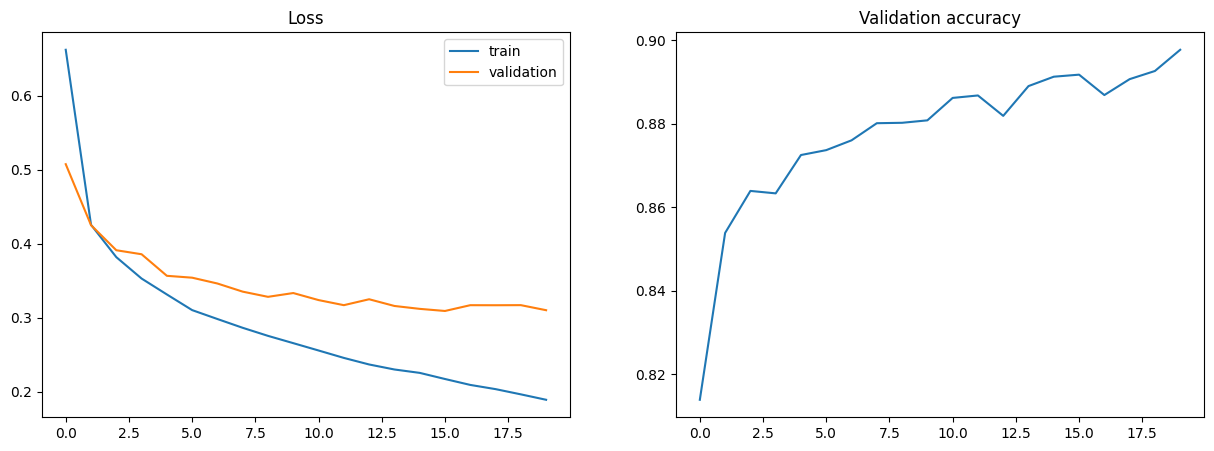

In [ ]:
n_epochs_1 = 20

train_loss_unreg, val_loss_unreg, val_accuracy_unreg = train_model(
    model,
    train_loader,
    test_loader,
    loss_func,
    opt,
    n_epochs_1
)

#### LETS NOW BUILD THE 3D PROJECTION OF A LOSS LANDSCAPE

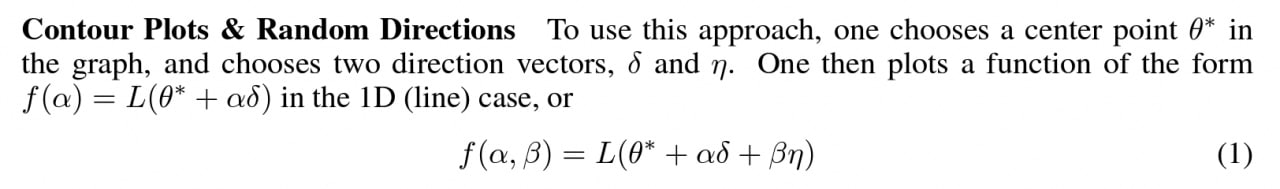

In [ ]:
w1, w2, params = collect_parameters(model)

In [ ]:
alphas = torch.linspace(-1, 1, 40)
betas  = torch.linspace(-1, 1, 40)

In [ ]:

A ,B  = np.meshgrid(alphas, betas)

In [ ]:
losses3d = draw_loss_landscape(model, params, w1, w2, train_loader)

In [ ]:



fig = go.Figure(data=[go.Surface(x = A,y=B, z=np.array(losses3d),)])

fig.update_layout(title='Loss Landscape Projection', autosize=False,
                width=500, height=500,
                margin=dict(l=65, r=50, b=65, t=90))
fig.show()

#### We can definitely see that the projection on 3d is not convex, so we KINDA can say, that the loss function landscape is non convex too

# BATCH NORM

https://www.pinecone.io/learn/batch-layer-normalization/


<!-- If you proceed to train your model on such datasets with input features on different scales, you’ll notice that the neural network takes significantly longer to train because the gradient descent algorithm takes longer to converge when the input features are not all on the same scale. Additionally, such high values can also propagate through the layers of the network leading to the accumulation of large error gradients that make the training process unstable, called the problem of exploding gradients. -->


#### Before talking about batch normalization we should talk about so called **covariant shift**. Covariant shift in machine learning is a type of model drift which occurs when the distribution of independent variables changes between the training environment and live environment. It occurs when the distribution of variables in the training data is different to real-world or testing data.

#### Some example

*Covariate drift can cause serious issues with speech recognition models because of the diversity of voices, dialects and accents in spoken word. For example, a model may be trained on English speakers from a specific area with a specific accent. Although the model may achieve a high degree of accuracy with the training data, it will become inaccurate when processing spoken language in a live environment. This is because processing speech with new dialects or accents will be a different input distribution to the training dat.*

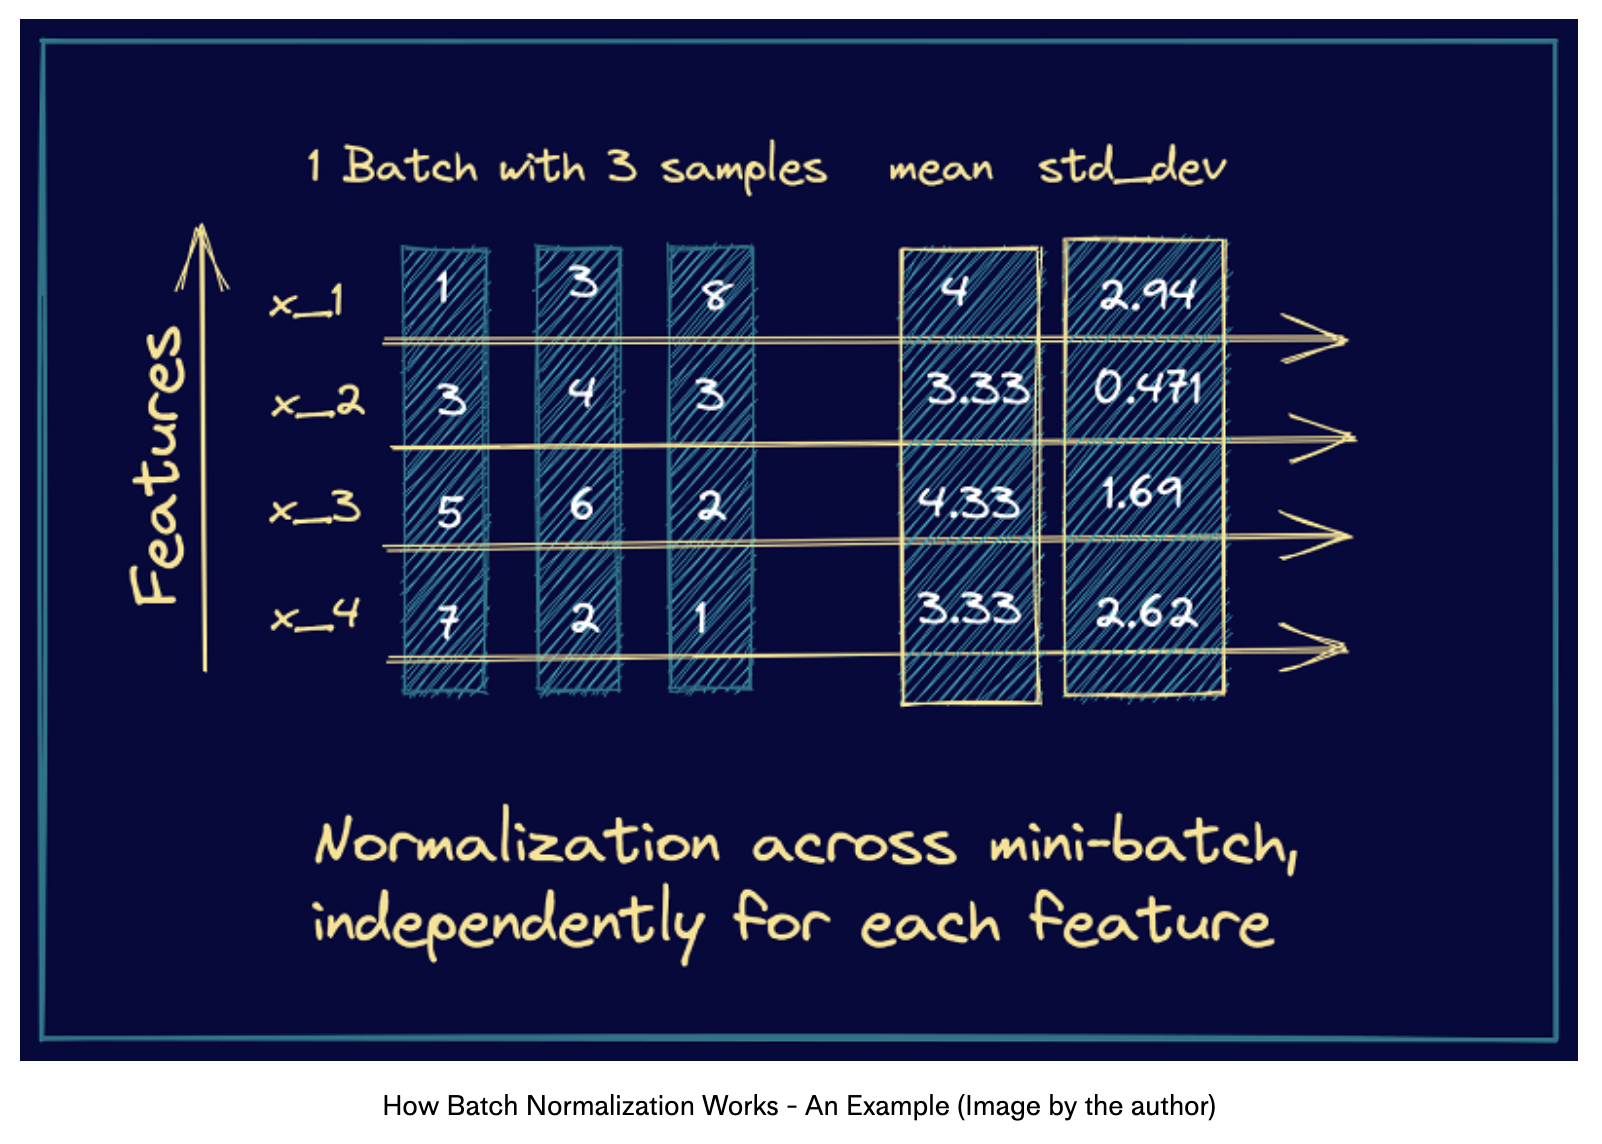

## Where to insert Batch Norm?

#### Anywhere, but  authers offer to insert it before non-linearity

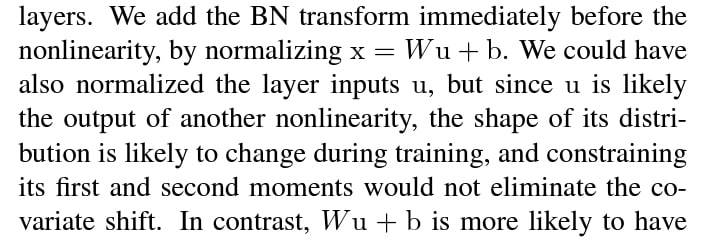


But when we have skip connections it is better to use BN before the layer

#### Fill in the model with dropout

In [ ]:
model_bn = nn.Sequential(
    nn.Flatten(),

    #insert your code with BatchNorm (BatchNorm1d)
    nn.Linear(input_shape, ...),

    nn.ReLU(),
    ...

    nn.Linear( ..., num_classes),

).to(device)

opt_bn = torch.optim.Adam(model_bn.parameters(), lr=3e-4)
loss_func_bn = nn.CrossEntropyLoss()

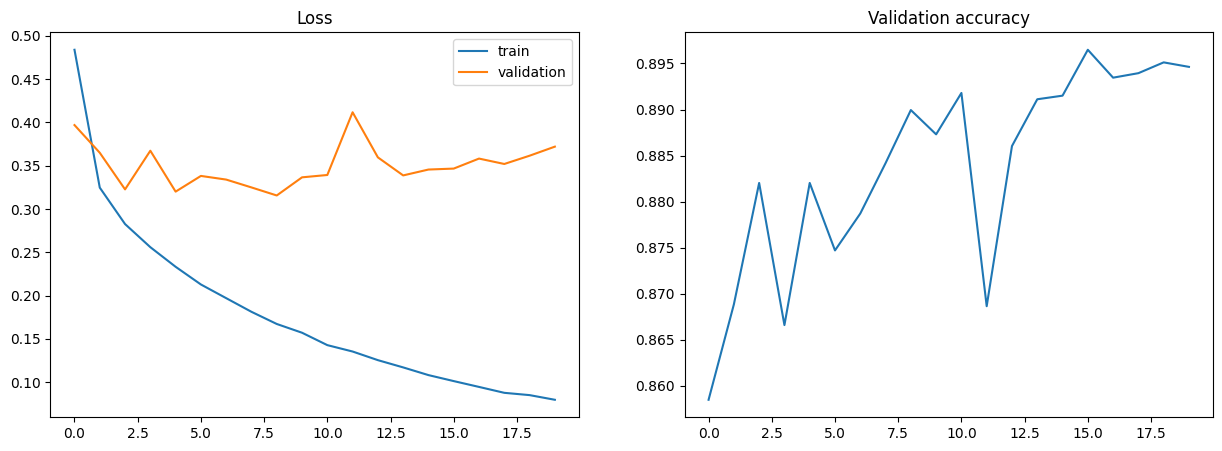

In [ ]:
n_epochs_1 = 20

train_loss_bn, val_loss_bn, val_accuracy_bn = train_model(
    model_bn,
    train_loader,
    test_loader,
    loss_func_bn,
    opt_bn,
    n_epochs_1
)

#### As over data and model are simple, we cannot see the expecting effect of BN

#### LETS NOW BUILD THE 3D PROJECTION OF A LOSS LANDSCAPE

In [ ]:
w1, w2, params = collect_parameters(model_bn)

In [ ]:
alphas = torch.linspace(-1, 1, 40)
betas  = torch.linspace(-1, 1, 40)

In [ ]:

A ,B  = np.meshgrid(alphas, betas)

In [ ]:
losses3d = draw_loss_landscape(model_bn, params, w1, w2,train_loader)

fig = go.Figure(data=[go.Surface(x = A,y=B, z=np.array(losses3d),)])

fig.update_layout(title='Loss Landscape Projection', autosize=False,
                width=500, height=500,
                margin=dict(l=65, r=50, b=65, t=90))
fig.show()

As we can see projection of the loss landscape become a little smoother

# LAYER NORM


Calculates the mean and the varience dor each instance separately all overthe features

#### Though BatchNorm was a revolutionary technique when it was created, It has some crucial drawbacks, we cannot help mention about

* Put constraints on a mini-batch
* Cannot be used in Recurrent NN
* Less suitable for NLP task

#### These issues could be shift just with "transposing" Batch Normalization into layer normalization

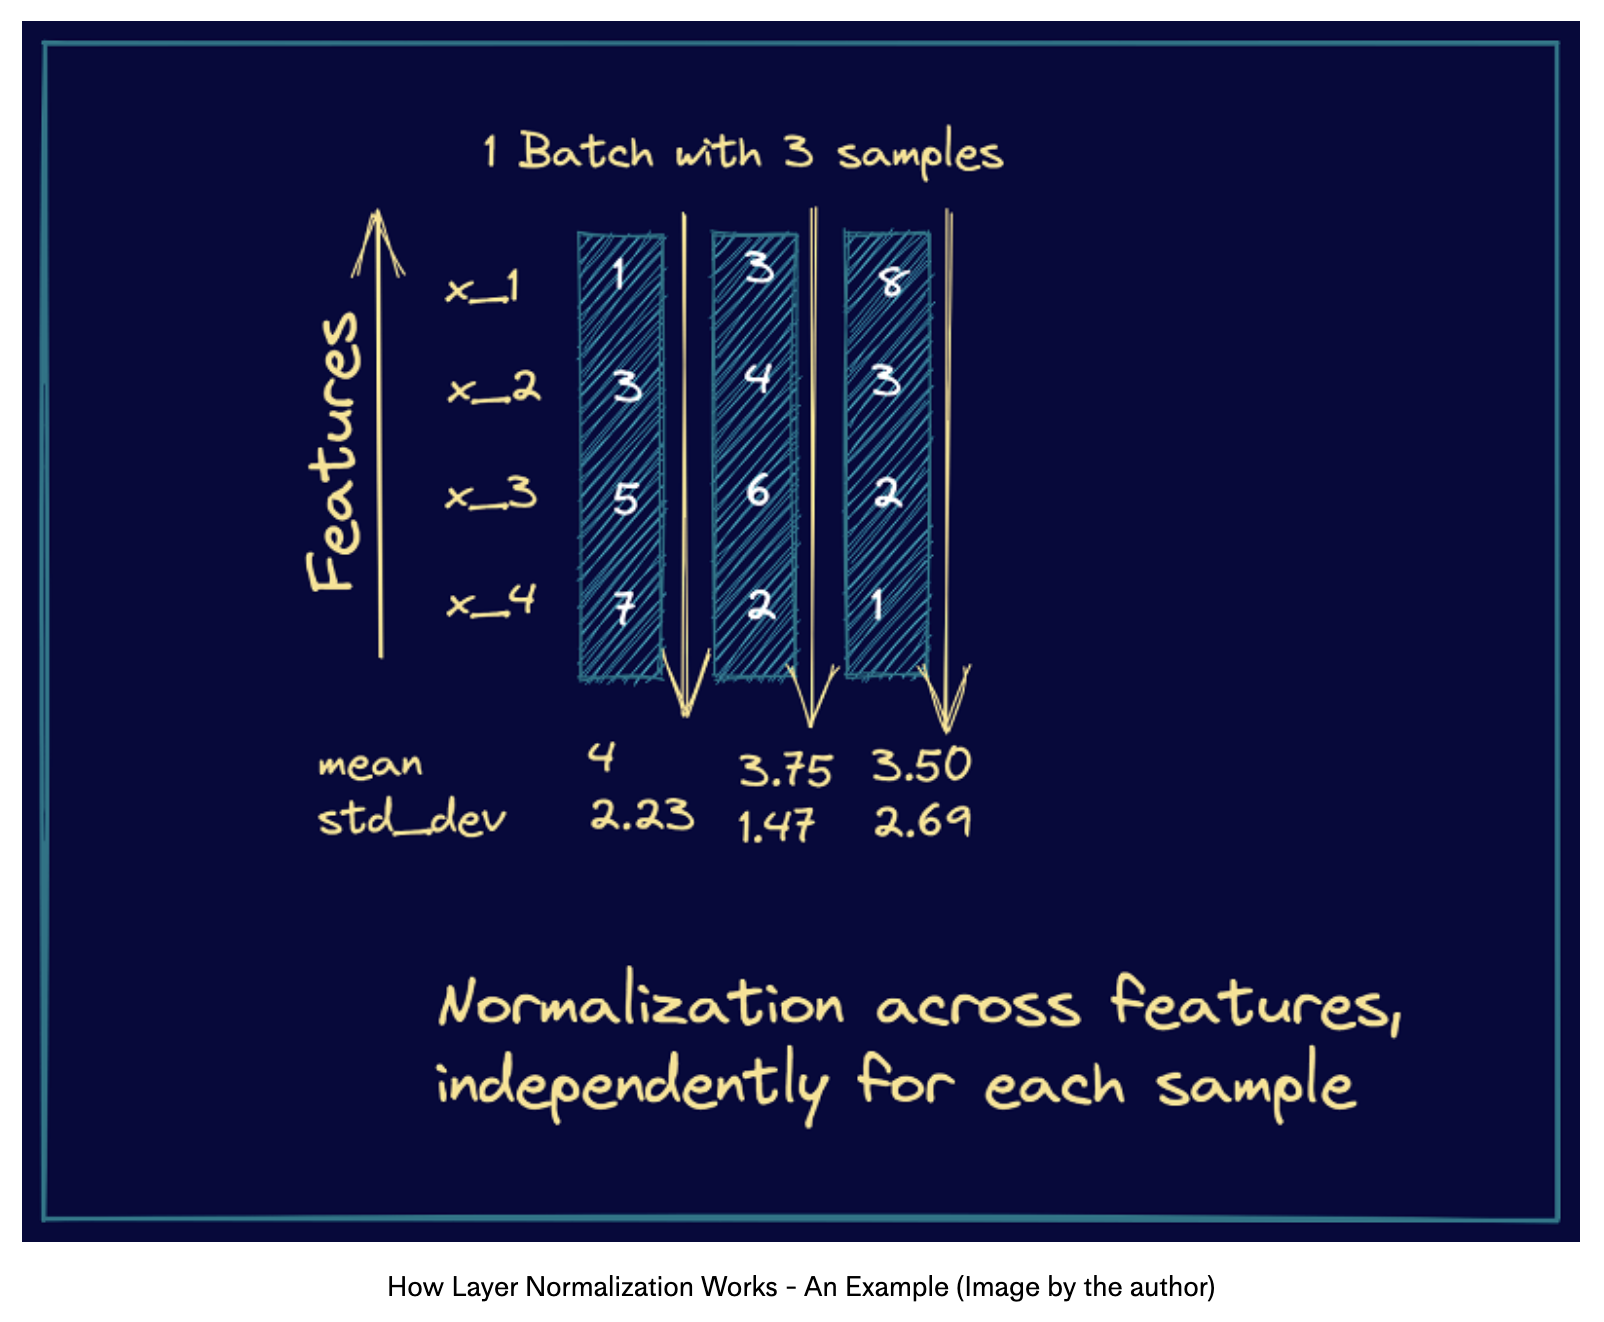

#### Fill in the model with layer norms

In [ ]:
model_ln = nn.Sequential(
    nn.Flatten(),

    # insert your code. use nn.LayerNorm()
    nn.Linear(input_shape, input_shape//2),
    ...
    nn.ReLU(),
    ...

    nn.Linear( input_shape//4, num_classes),

).to(device)

opt_ln = torch.optim.Adam(model_ln.parameters(), lr=3e-4)
loss_func_ln = nn.CrossEntropyLoss()

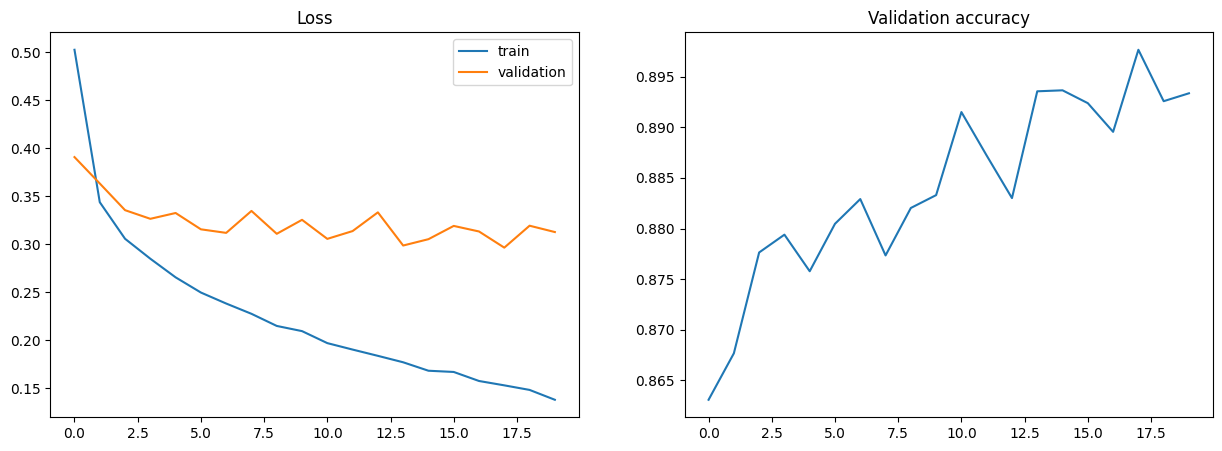

In [ ]:
n_epochs_1 = 20

train_loss_ln, val_loss_ln, val_accuracy_ln = train_model(
    model_ln,
    train_loader,
    test_loader,
    loss_func_ln,
    opt_ln,
    n_epochs_1)

#### Let's look at the projection of loss landscape

In [ ]:
w1, w2, params = collect_parameters(model_ln)

In [ ]:
alphas = torch.linspace(-1, 1, 40)
betas  = torch.linspace(-1, 1, 40)

In [ ]:

A ,B  = np.meshgrid(alphas, betas)

In [ ]:
losses3d = draw_loss_landscape(model_ln, params, w1, w2,train_loader)

fig = go.Figure(data=[go.Surface(x = A,y=B, z=np.array(losses3d),)])

fig.update_layout(title='Loss Landscape Projection', autosize=False,
                width=500, height=500,
                margin=dict(l=65, r=50, b=65, t=90))
fig.show()

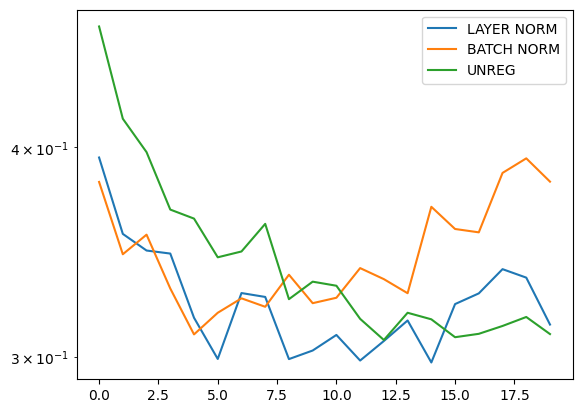

In [ ]:
plt.semilogy(val_loss_ln, label='LAYER NORM')
plt.semilogy( val_loss_bn, label='BATCH NORM')
plt.semilogy(val_loss_unreg, label='UNREG')
plt.legend()
plt.show()

#### We can see that for our toy example, Layer normalization provided the best performance

# REGULARIZATION


## DROPOUT

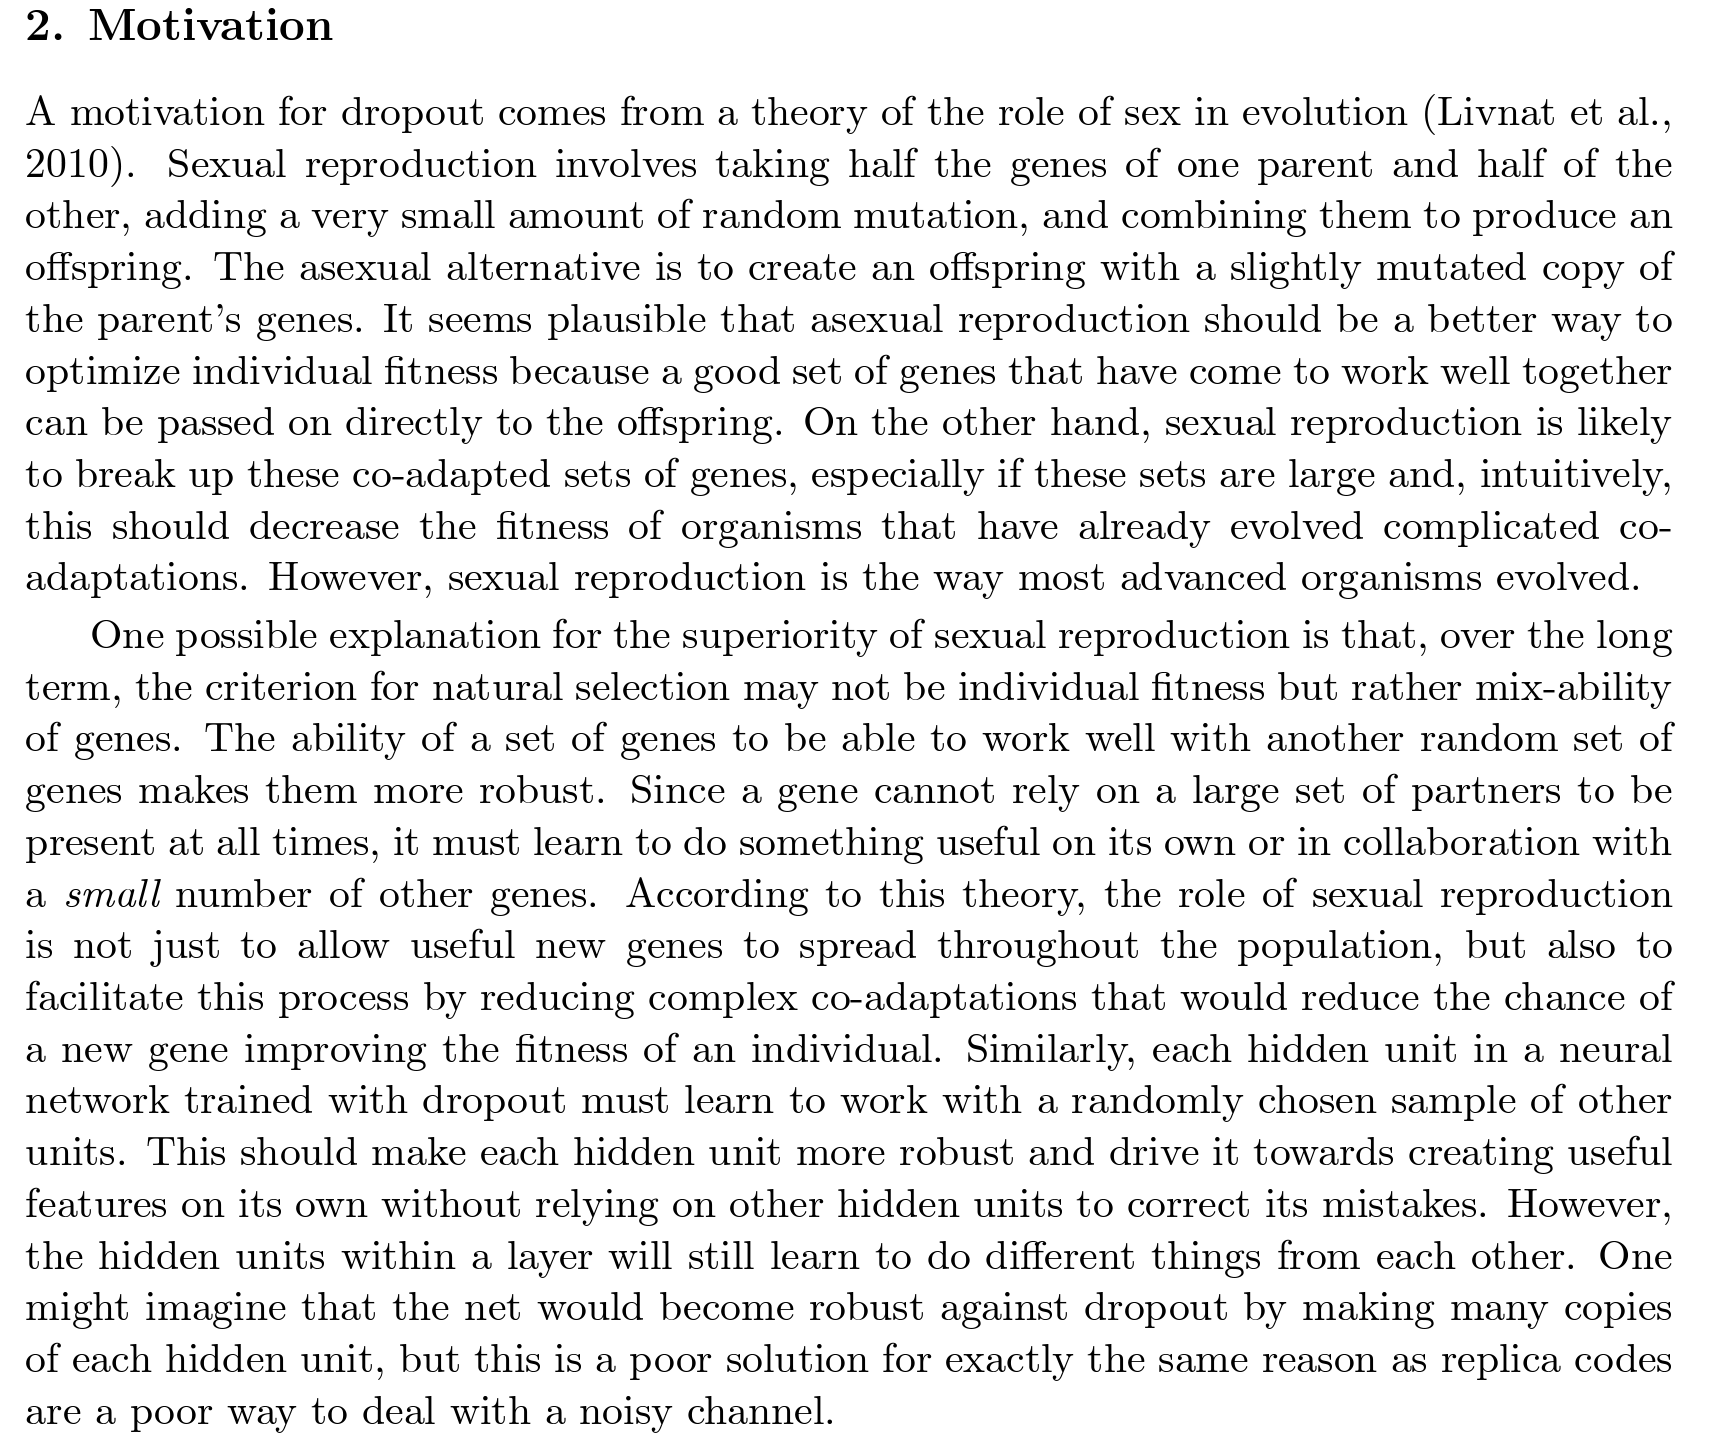

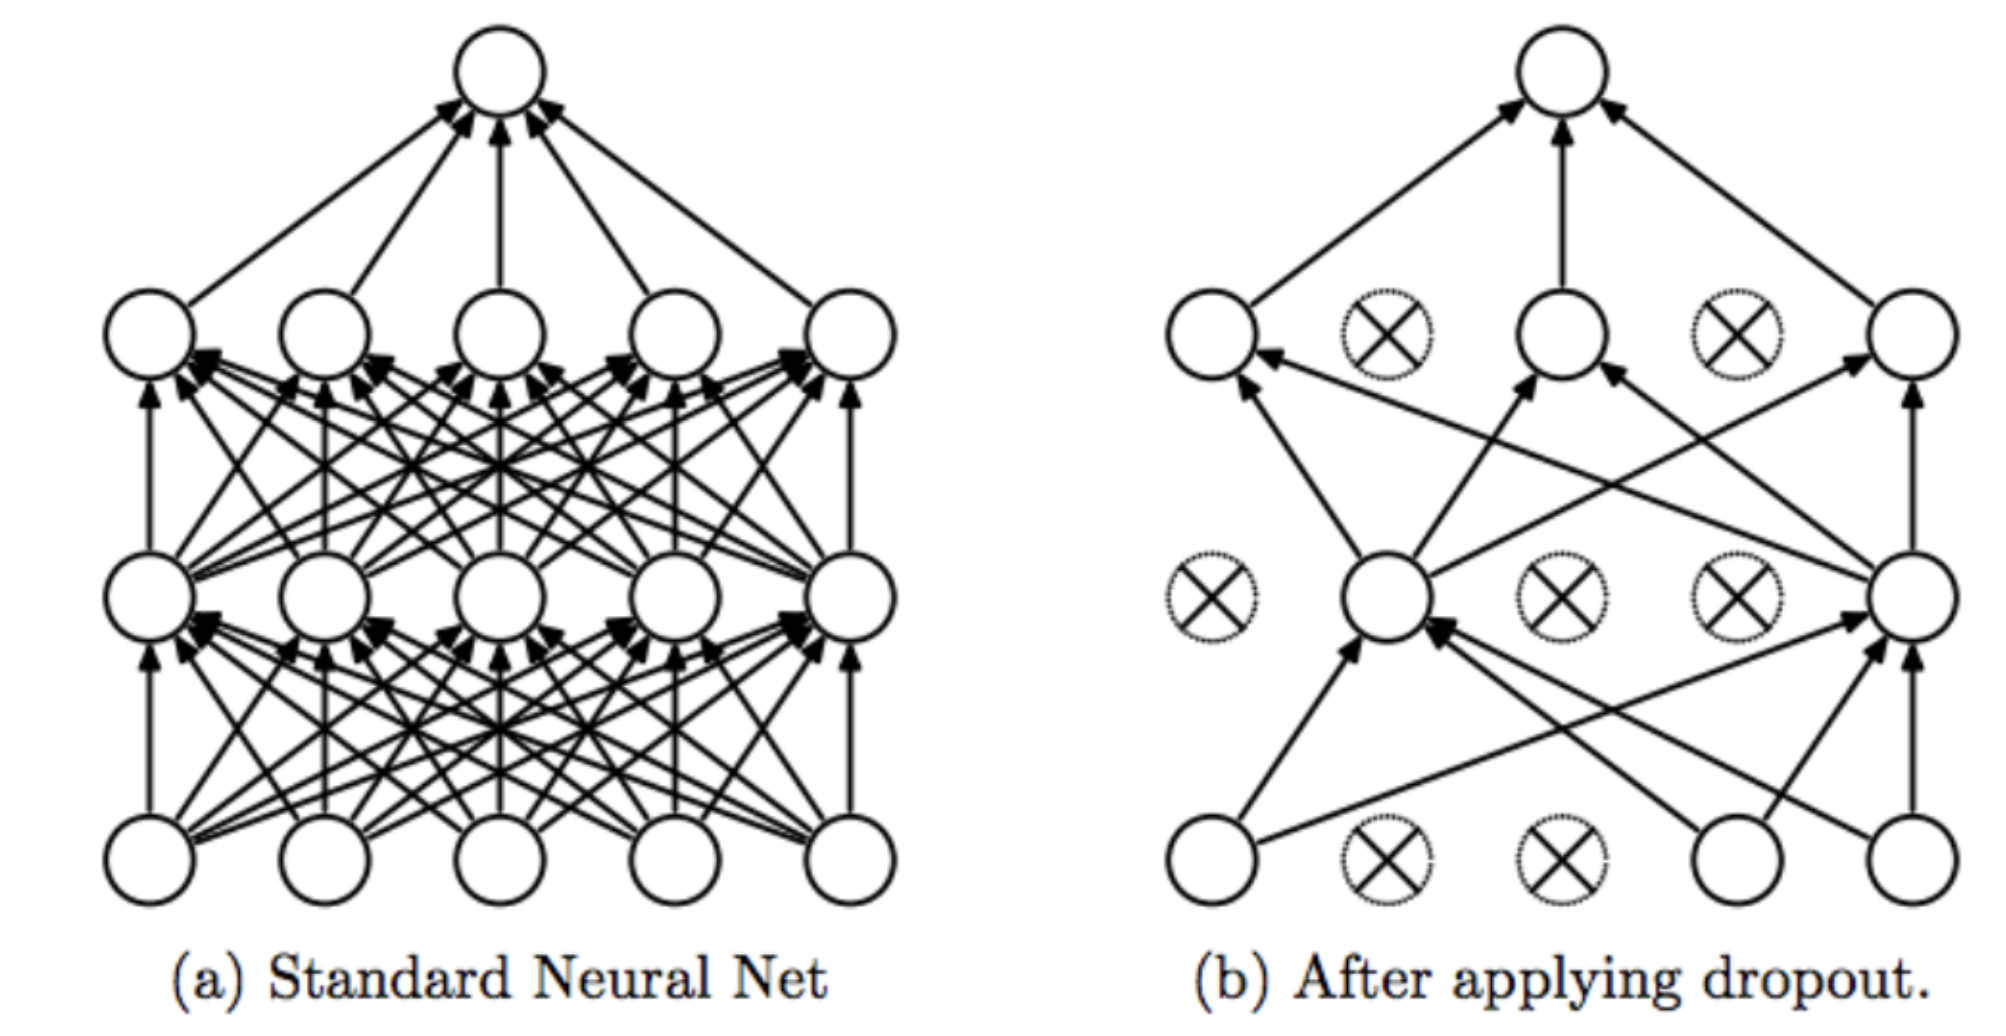

#### p - probability to turn off nueron

####  Large models are proned to overfitting

With unlimited computational resources, the most effective method to "regularize" a fixed-sized model is to average the predictions of all possible parameter settings, weighting each setting based on its posterior probability given the training data.

Training numerous architectures is challenging due to the complexity of finding optimal hyperparameters for each one and the substantial computational resources required to train large networks. Additionally, large networks typically necessitate abundant training data, which may not always be available to train various networks on different data subsets. Even if multiple large networks could be trained, using them all at test time is impractical in scenarios where rapid response is crucial.

Dropout, a technique that addresses these challenges, prevents overfitting and offers an efficient way to combine a vast number of neural network architectures.


#### Dropout acts differently on training and validation phases.


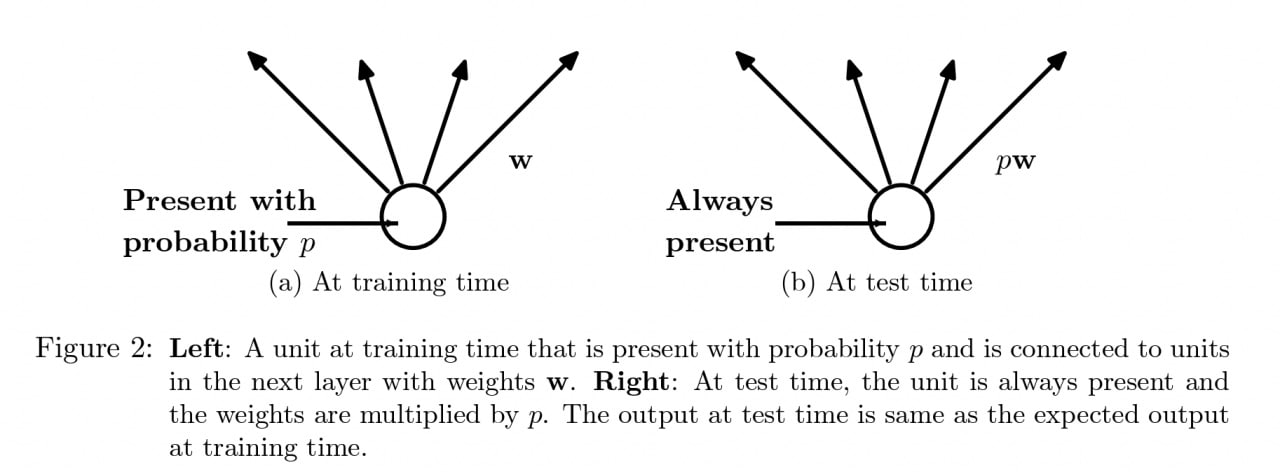


#### Fill in the model with dropout

In [ ]:
model_do = nn.Sequential(
    nn.Flatten(),
    # insert the dropout regularization into the net
    nn.Linear(input_shape, ...),
    ...
    nn.ReLU(),
    ....

    nn.Linear( ..., num_classes),

).to(device)

opt_do = torch.optim.Adam(model_do.parameters(), lr=3e-4)
loss_func_do = nn.CrossEntropyLoss()

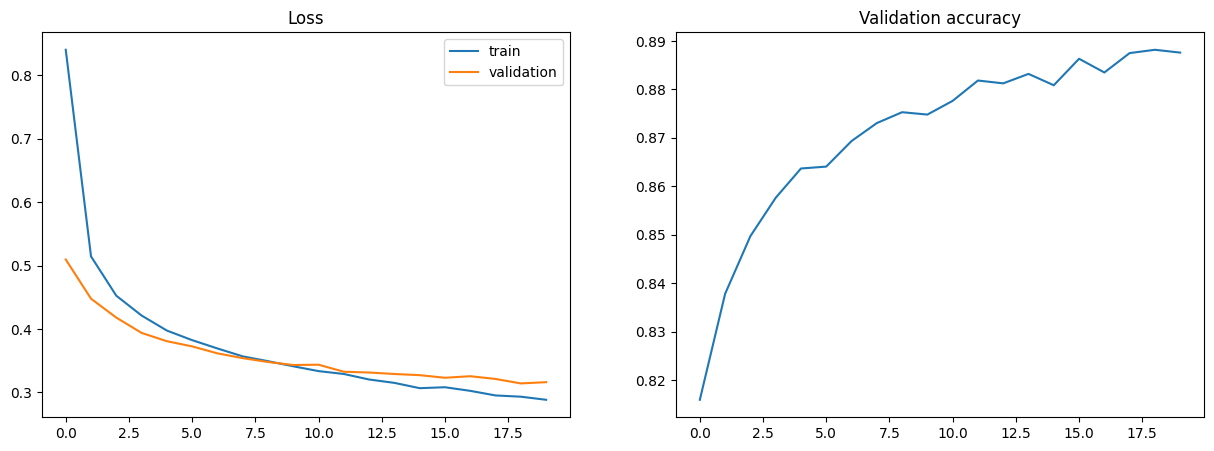

In [ ]:
n_epochs_1 = 20

train_loss_do, val_loss_do, val_accuracy_do = train_model(
    model_do,
    train_loader,
    test_loader,
    loss_func_do,
    opt_do,
    n_epochs_1
)

## L1 REGULARIZATION

#### L1 regularization in NN has the same effect as in ML models (like logistic regression). It is prone to sparsify the tensor

#### Fill in the perceptron model

In [ ]:
class MLP_model(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, input_shape):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(input_shape, input_shape//2),
      nn.ReLU(),
      nn.Linear(input_shape//2, input_shape//4),
      nn.ReLU(),
      nn.Linear( input_shape//4, 10)
    )





  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

  def compute_l2_loss(self, w):
      # insert your code
      return ...

  def compute_l1_loss(self, w):
      # insert your code
      return ...

#### Fill in the train function

In [ ]:

def train_reg(model, train_loader, val_loader, loss_fn, opt, reg,n_epochs: int, build_plot=True):
    train_loss = []
    val_loss = []
    val_accuracy = []


    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True)
        for X_batch, y_batch in train_loader:
          #zero grad
            opt.zero_grad()

            # to device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model(X_batch)
            loss =loss_func(predictions, y_batch)

            if reg == 'l1':
              l1_weight = 0.001
              l1_parameters = []
              for parameter in model.parameters():
                  # insert your code
                  l1_parameters.append(..)
              l1 = ...
              loss += l1.to(device)

            if reg == 'l2':
              l2_weight = 0.001
              l2_parameters = []
              for parameter in model.parameters():
                   # insert your code
                  l2_parameters.append()
              l2 = ...
              loss += l2
            #back step
            loss.backward()
            # optimizer step
            opt.step()

            ep_train_loss.append(loss.item())

        model.train(False)
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:

                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                predictions = model(X_batch)
                loss = loss_func(predictions, y_batch)

                ep_val_loss.append(loss.item())
                y_pred = predictions.max(1)[1].data
                ep_val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        if build_plot:
            plot_train_process(train_loss, val_loss, val_accuracy)
    return train_loss, val_loss, val_accuracy
# __________end of block__________

In [ ]:
model_l1 = MLP_model(input_shape).to(device)

opt_l1 = torch.optim.Adam(model_l1.parameters(), lr=3e-4)
loss_func_l1 = nn.CrossEntropyLoss()

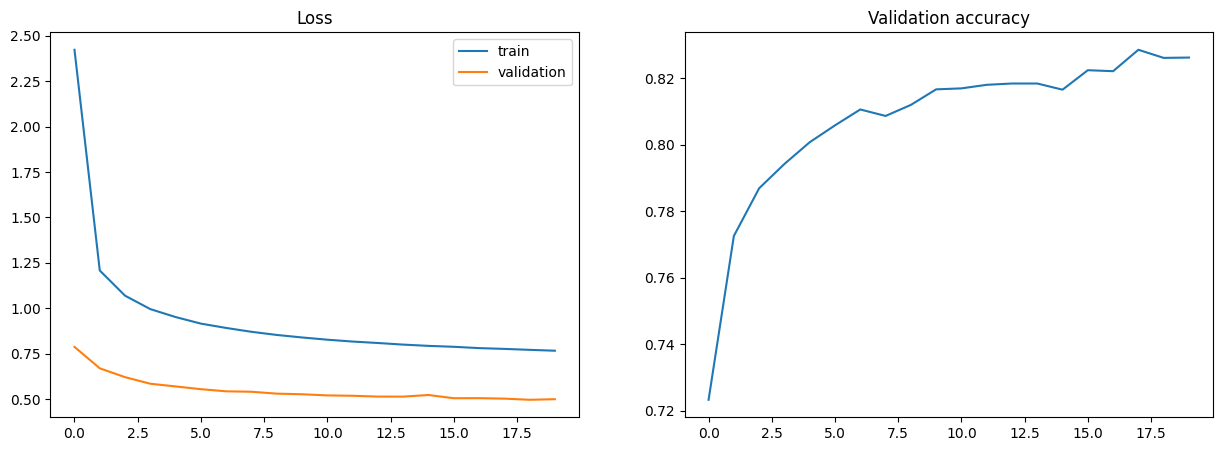

In [ ]:
n_epochs_1 = 20

train_loss_l1, val_loss_l1, val_accuracy_l1 = train_reg(
    model_l1,
    train_loader,
    test_loader,
    loss_func_l1,
    opt_l1,
    'l1',
    n_epochs_1,

)

Let's draw the first layer weights of a model  trained with dropout

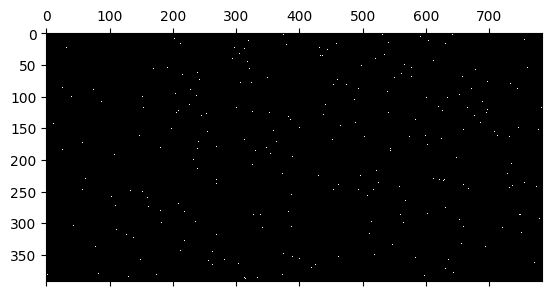

In [ ]:

plt.spy(model_do[1].weight.detach().cpu().numpy(), precision=1e-4)

And here we draw the first layer weights of a model trained with l1

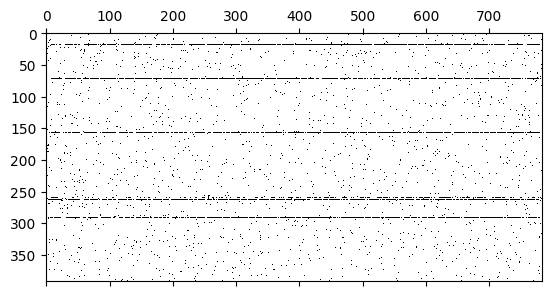

In [ ]:
plt.spy(model_l1.layers[1].weight.detach().cpu().numpy(), precision=1e-4)

l1 works!

# L2 REGULARIZATION

#### As in ML models, L2 regularization prohibits weights values to be too big

In [ ]:
model_l2 = MLP_model(input_shape).to(device)

opt_l2 = torch.optim.Adam(model_l2.parameters(), lr=3e-4)
loss_func_l2 = nn.CrossEntropyLoss()

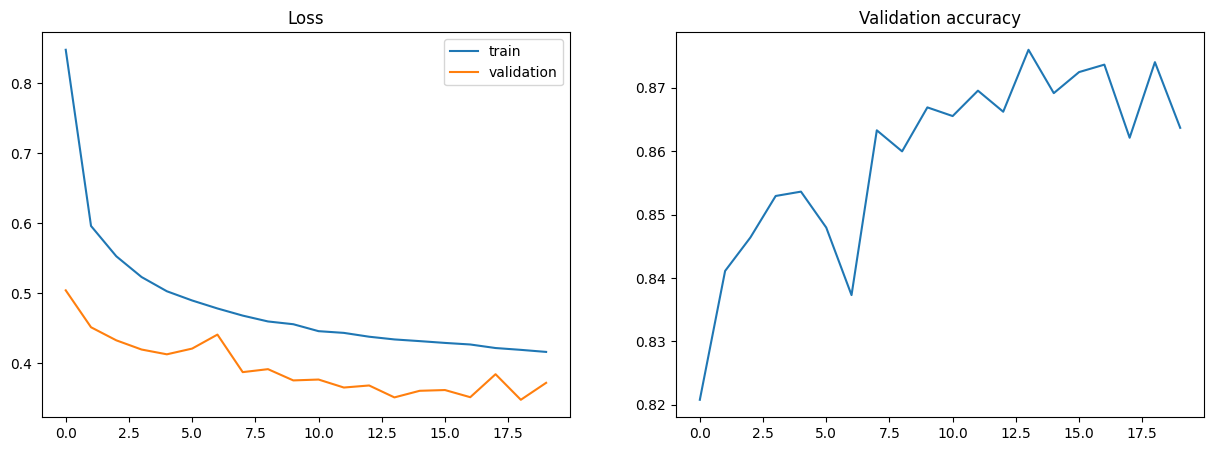

In [ ]:
n_epochs_1 = 20

train_loss_l2, val_loss_l2, val_accuracy_l2 = train_reg(
    model_l2,
    train_loader,
    test_loader,
    loss_func_l2,
    opt_l2,
    'l2',
    n_epochs_1,

)

#### distribution of the weights with the model trained without any regularization

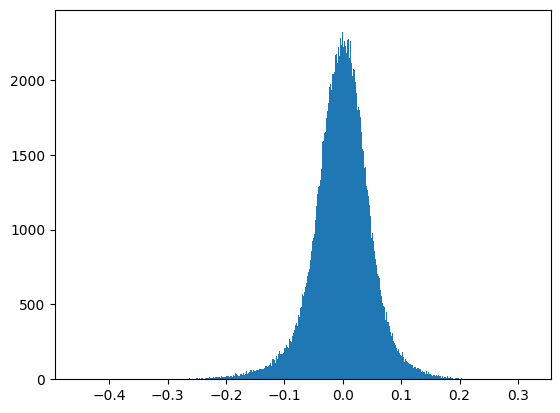

In [ ]:
plt.hist(model[1].weight.detach().cpu().numpy().reshape(1, -1)[0], bins = 1000);

#### distribution of the weights with the model trained with l2 regularization

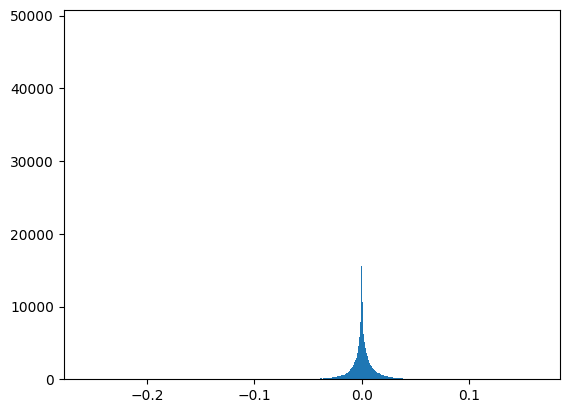

In [ ]:
plt.hist(model_l2.layers[1].weight.detach().cpu().numpy().reshape(1, -1)[0], bins = 1000);

## Why is it working like that??

Imagine you have vector $\vec{x}=(1, \epsilon)$ where $\epsilon >0$ is small. $l1$ and $l2$ norms are given like that:

$$
\|\vec{x}\|^2_2 = 1+\epsilon^2
$$

$$
\|\vec{x}\|_1 = 1+\epsilon
$$

Suppose, we update our vector with the vector of $v = (\delta, 0)$

LEt's look at norms of vector $x-v$

$$
\|x-v\|^2_2 = 1-2\delta + \delta^2 + \epsilon^2
$$

$$
\|x-v\|_1 = 1-\delta + \epsilon
$$


Let's now put $d = (0, \delta)$

$$
\|x-d\|^2_2 = 1-2\delta \epsilon + \delta^2 + \epsilon^2
$$

$$
\|x-d\|_1 = 1-\delta + \epsilon
$$


We can see that the that L2 regularization is prone to reduce the bigger weights, whereas L1 regularization does'not draw any attantion on the magnitude of the weights